In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import clear_output
%matplotlib inline

In [2]:
celebs = ['Irrfan_Khan', 'Jacqueline_Fernandez', 'Juhi_Chawla', 
          'Kajal_Aggarwal', 'Paresh_Rawal']

In [3]:
os.chdir('data/celeb_faces_dataset')
if os.path.isdir('train/Irrfan_Khan/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for c in celebs:
        shutil.move(f'{c}', 'train')
        os.mkdir(f'valid/{c}')
        os.mkdir(f'test/{c}')

        valid_samples = random.sample(os.listdir(f'train/{c}'), 30)
        for i in valid_samples:
            shutil.move(f'train/{c}/{i}', f'valid/{c}')

        test_samples = random.sample(os.listdir(f'train/{c}'), 5)
        for j in test_samples:
            shutil.move(f'train/{c}/{j}', f'test/{c}')
os.chdir('../..')

In [4]:
train_path = 'data/celeb_faces_dataset/train'
valid_path = 'data/celeb_faces_dataset/valid'
test_path = 'data/celeb_faces_dataset/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
               .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 278 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [6]:
inception = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False)
for layer in inception.layers:
    layer.trainable = False
inception.summary()

87916544/87910968 [==============================] - 15s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________

In [7]:
top_model = inception.output

In [8]:
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(512, activation='relu')(top_model)

In [9]:
top_model = Dense(units=5, activation='softmax')(top_model)

In [10]:
model = Model(inputs=inception.input, outputs=top_model)

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [14]:
callbacks_list = [PlotLearning()]

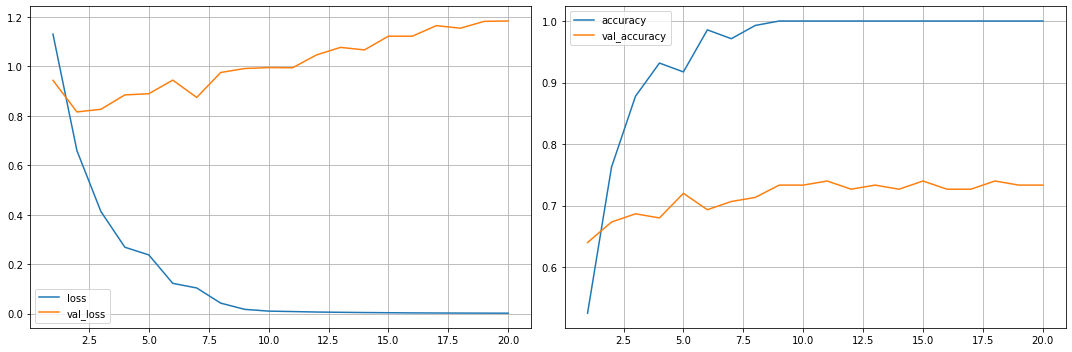

56/56 - 15s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1841 - val_accuracy: 0.7333


In [15]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=2,
            callbacks=callbacks_list
)

In [16]:
test_labels = test_batches.classes

In [17]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [18]:
predictions

array([[9.99999523e-01, 4.43917969e-09, 2.17978467e-07, 2.20994467e-09,
        2.43692114e-07],
       [9.97967660e-01, 1.05540303e-05, 1.12811204e-05, 1.40269052e-09,
        2.01046560e-03],
       [9.99966979e-01, 1.12712701e-08, 3.41790224e-06, 1.90841263e-08,
        2.95611335e-05],
       [9.93942320e-01, 2.02258852e-05, 1.54252139e-05, 1.60137681e-08,
        6.02203980e-03],
       [9.99767601e-01, 4.36566339e-08, 6.45495584e-06, 2.79501734e-07,
        2.25699361e-04],
       [6.03768494e-05, 5.08159883e-02, 9.43403721e-01, 5.70323970e-03,
        1.67843955e-05],
       [1.77666134e-05, 1.25330093e-03, 2.49485532e-03, 9.95581806e-01,
        6.52314688e-04],
       [2.45822071e-06, 9.94066834e-01, 3.26418615e-07, 1.15522227e-04,
        5.81473392e-03],
       [1.06422422e-05, 8.57418478e-02, 9.13691819e-01, 5.26502263e-04,
        2.91569795e-05],
       [4.28361272e-06, 9.56068695e-01, 3.69513966e-02, 6.94942102e-03,
        2.61244531e-05],
       [8.02601717e-05, 3.8208

In [19]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'Irrfan_Khan': 0,
 'Jacqueline_Fernandez': 1,
 'Juhi_Chawla': 2,
 'Kajal_Aggarwal': 3,
 'Paresh_Rawal': 4}

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 2 2 1 0]
 [1 1 3 0 0]
 [0 0 0 5 0]
 [1 0 0 0 4]]


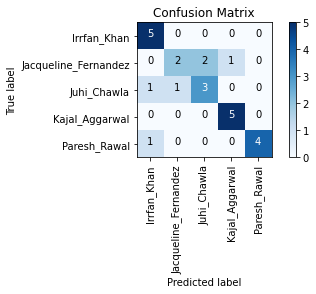

In [22]:
cm_plot_labels = celebs[:]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
model.save('models\model_73.33_Inception.h5')